In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

In [2]:
class PatchCraftDataset(Dataset):
    def __init__(self, root_dir, transform=None, sample_fraction=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        categories = ["ai", "nature"]
        labels = {"ai": 1, "nature": 0}

        for category in categories:
            rich_dir = os.path.join(root_dir, category, "rich")
            poor_dir = os.path.join(root_dir, category, "poor")

            rich_images = sorted(os.listdir(rich_dir))
            poor_images = sorted(os.listdir(poor_dir))
            num_samples = min(len(rich_images), len(poor_images))

            for i in range(num_samples):
                rich_path = os.path.join(rich_dir, rich_images[i])
                poor_path = os.path.join(poor_dir, poor_images[i])
                self.samples.append((rich_path, poor_path, labels[category]))

        if sample_fraction < 1.0:
            reduced_size = int(sample_fraction * len(self.samples))
            self.samples = random.sample(self.samples, reduced_size)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rich_path, poor_path, label = self.samples[idx]
        
        rich_img = Image.open(rich_path).convert("RGB")
        poor_img = Image.open(poor_path).convert("RGB")

        if self.transform:
            rich_img = self.transform(rich_img)
            poor_img = self.transform(poor_img)

        return torch.cat((rich_img, poor_img), dim=0), torch.tensor(label, dtype=torch.long)

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = PatchCraftDataset(root_dir="data/processed_train/raw", transform=transform, sample_fraction=1)

num_samples = len(dataset)
num_val = int(0.1 * num_samples)
num_train = num_samples - num_val
train_data, val_data = random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)

In [4]:
device = torch.device("cuda")
device

device(type='cuda')

In [5]:
base_model = models.resnet18(pretrained=True)

base_model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)

base_model.fc = nn.Linear(base_model.fc.in_features, 2)

model = base_model.to(device)

C:\Users\Kate\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kate\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
num_epochs = 10
train_losses, val_losses = [], []
best_val_loss = float("inf")
early_stop_patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    print(f"\n Epoch {epoch+1}/{num_epochs} ---------------------")
    
    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}", end="\r")

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "fine_tuned_patchcraft-baseline-patchcraft.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("\nEarly stopping triggered. Training stopped.")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Fine-Tuning Complete!")


 Epoch 1/10 ---------------------
Epoch [1/10] - Train Loss: 0.1209, Val Loss: 0.1005

 Epoch 2/10 ---------------------
Epoch [2/10] - Train Loss: 0.0733, Val Loss: 0.1601

 Epoch 3/10 ---------------------
Epoch [3/10] - Train Loss: 0.0546, Val Loss: 0.0883

 Epoch 4/10 ---------------------
Epoch [4/10] - Train Loss: 0.0420, Val Loss: 0.2921

 Epoch 5/10 ---------------------
Epoch [5/10] - Train Loss: 0.0421, Val Loss: 0.0795

 Epoch 6/10 ---------------------
Epoch [6/10] - Train Loss: 0.0286, Val Loss: 0.0836

 Epoch 7/10 ---------------------
Epoch [7/10] - Train Loss: 0.0255, Val Loss: 0.0735

 Epoch 8/10 ---------------------
Epoch [8/10] - Train Loss: 0.0236, Val Loss: 0.0819

 Epoch 9/10 ---------------------
Epoch [9/10] - Train Loss: 0.0204, Val Loss: 0.1138

 Epoch 10/10 ---------------------
Batch 788/788 - Loss: 0.0002
Early stopping triggered. Training stopped.
Fine-Tuning Complete!


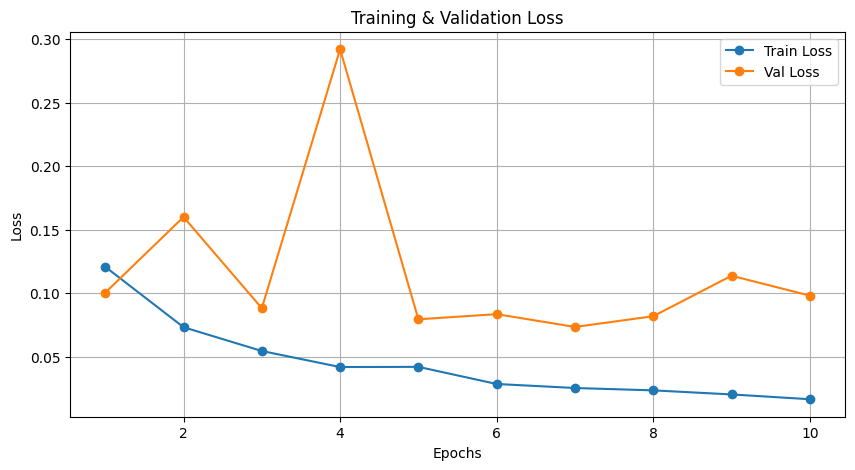

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, 11), val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()